# Week 4 Mini Project: Natural Language Processing with Disaster Tweets

**The Data Challenge Source:** https://www.kaggle.com/c/nlp-getting-started/

**My Github Link:** https://github.com/lzheng01/NLP-with-Disaster-Tweets

________
# 1. Introduction
________

### The data challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## 1.1  Directory Setup and Libraries Installation

In [1]:
#import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
import csv
from tqdm import tqdm


In [2]:
# Setup my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#label file paths
current_dir = os.getcwd()
path_dir = os.path.join(current_dir, '/content/drive/My Drive/NLP/nlp-getting-started/')
train_path = path_dir + 'train.csv'
test_path = path_dir + 'test.csv'

#import data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Number of training data: {}".format(len(train)))
print("Number of test data: {}".format(len(test)))

Number of training data: 7613
Number of test data: 3263


### The entire dataset includes 10,000 tweets, which 7,613 tweets are in the trainingfile, and 3,263 in the test file. The data was split in a 2:1 ratio.

## 1.2 Exploratory Analysis (EDA)

In [4]:
# Display the first few records of the training dataset
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Display the first records of the test dataset
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# Check the descriptive statistics (Mean/Max/Min) for the length of text
train['text_length'] = train['text'].apply(lambda x: len(x))
test['text_length'] = test['text'].apply(lambda x: len(x))
print(f'Mean Train text length: {train["text_length"].mean()}')
print(f'Mean Test text length: {test["text_length"].mean()}')
print(f'Max Train text length: {train["text_length"].max()}')
print(f'Max Test text length: {test["text_length"].max()}')
print(f'Min Train text length: {train["text_length"].min()}')
print(f'Min Test text length: {test["text_length"].min()}')

Mean Train text length: 101.03743596479706
Mean Test text length: 102.10818265399939
Max Train text length: 157
Max Test text length: 151
Min Train text length: 7
Min Test text length: 5


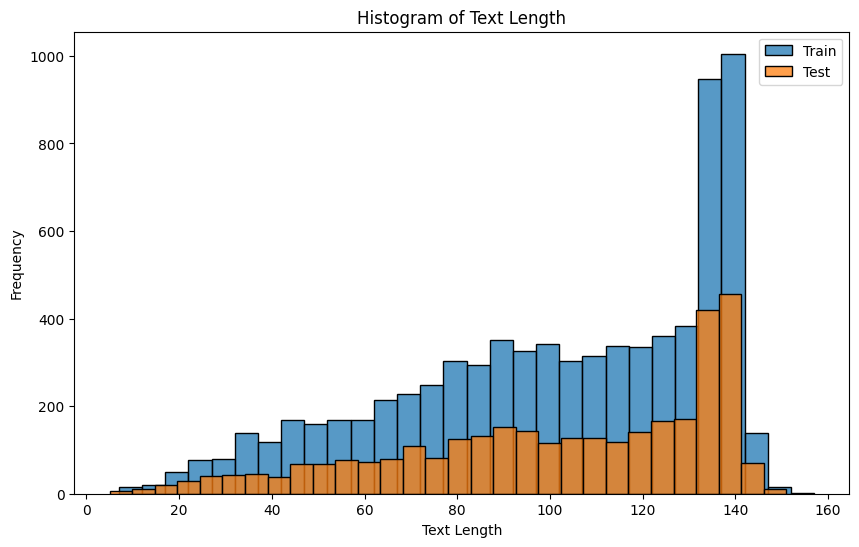

In [7]:
# Plot the distribution of the text length
plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=30, label='Train')
sns.histplot(test['text_length'], bins=30, label='Test')
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### The training and test data have smiliar distributions. The majority of tweets posted 120-150 words.

In [8]:
# Check the missing values and duplicates in the training dataset
missing_values = train.isnull().sum()
print(missing_values)
duplicated_rows = train.duplicated().sum()
print(f'{duplicated_rows} duplicates in labels')

id                0
keyword          61
location       2533
text              0
target            0
text_length       0
dtype: int64
0 duplicates in labels


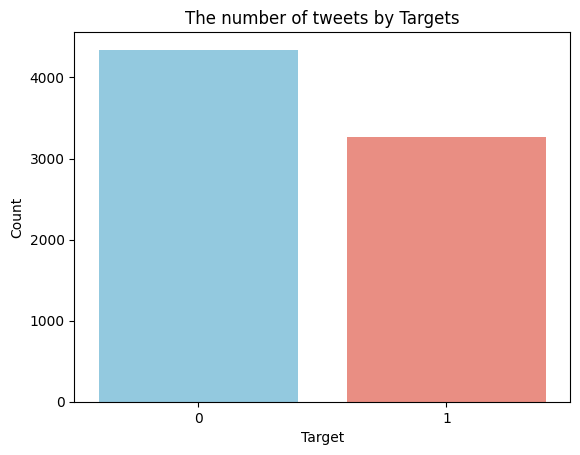

In [9]:
# Plot the frequency of Targets
category_counts = train['target'].value_counts()

ax = sns.countplot(x='target', hue='target', data=train, palette=['skyblue', 'salmon'], legend=False)
ax.set_title('The number of tweets by Targets')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
plt.show()

In [10]:
# Download stopwords from NLTK
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

# Add custom stopwords
additional_stopwords = {'https', 'co', 'amp', 'new', 'u', 'im', 'via'}
stop_words = set(stopwords.words('english')).union(additional_stopwords)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [word for word, tag in tagged_tokens if word not in stop_words and tag != 'VBD']
    text = ' '.join(filtered_tokens)
    return text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Apply clean_text function
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

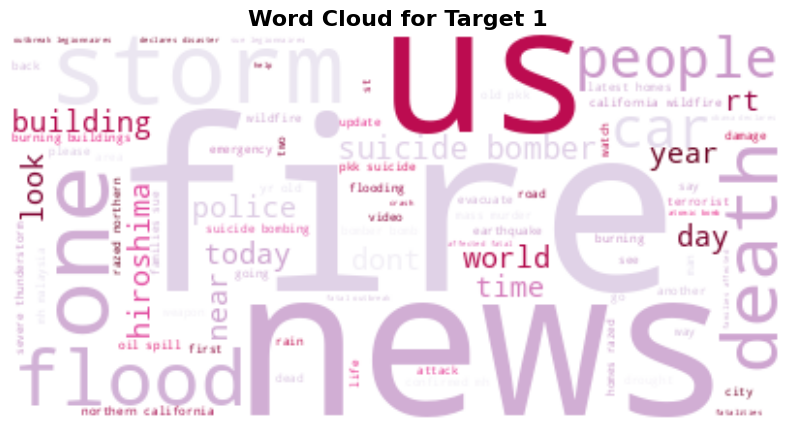

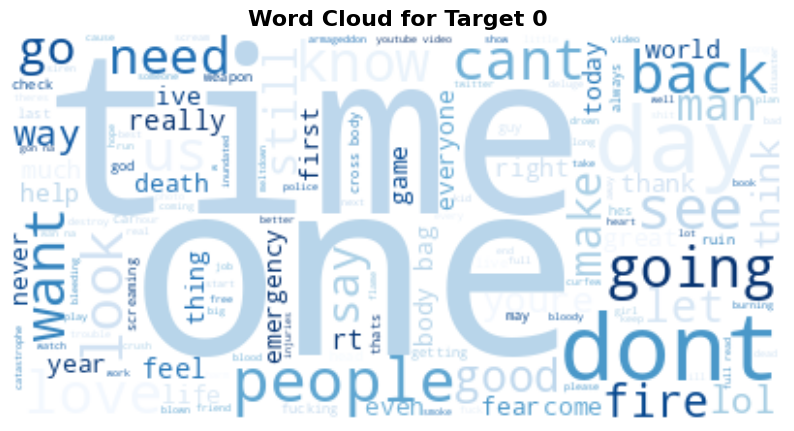

In [12]:
# Plot word clouds
target_colormaps = {
    0: 'Blues',
    1: 'PuRd'
}

for target in train['target'].unique():
    text = " ".join(txt for txt in train[train['target'] == target]['clean_text'])
    wordcloud = WordCloud(background_color="white", colormap=target_colormaps[target]).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Target {target}", fontsize=16, fontweight='bold')
    plt.show()

In [13]:
def transform_text(df, keyword_weight=3, location_weight=3):
    """
    Transforms the input DataFrame by emphasizing 'keyword' and 'location' fields.

    Args:
        df (pd.DataFrame): DataFrame containing 'keyword', 'location', and 'text' columns.
        keyword_weight (int): Number of times to repeat 'keyword' to emphasize it.
        location_weight (int): Number of times to repeat 'location' to emphasize it.

    Returns:
        pd.DataFrame: DataFrame with an added 'input_text' column containing the transformed text.
    """
    df['keyword'] = df['keyword'].fillna('')
    df['location'] = df['location'].fillna('')
    df['input_text'] = (df['keyword'] + ' ') * keyword_weight + (df['location'] + ' ') * location_weight + df['clean_text']
    return df

In [14]:
train = transform_text(train, keyword_weight=3, location_weight=3)
test = transform_text(test, keyword_weight=3, location_weight=3)

In [15]:
train.head(10)

,id,keyword,location,text,target,text_length,clean_text,input_text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us,deeds reason earthquake may allah forgiv...
1,4,,,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,,,All residents asked to 'shelter in place' are ...,1,133,residents shelter place notified officers evac...,residents shelter place notified officer...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders cal...,people receive wildfires evacuation orde...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,88,got photo ruby alaska smoke wildfires pours sc...,got photo ruby alaska smoke wildfires po...
5,8,,,#RockyFire Update => California Hwy. 20 closed...,1,110,rockyfire update california hwy closed directi...,rockyfire update california hwy closed d...
6,10,,,#flood #disaster Heavy rain causes flash flood...,1,95,flood disaster heavy rain causes flash floodin...,flood disaster heavy rain causes flash f...
7,13,,,I'm on top of the hill and I can see a fire in...,1,59,top hill see fire woods,top hill see fire woods
8,14,,,There's an emergency evacuation happening now ...,1,79,theres emergency evacuation happening building...,theres emergency evacuation happening bu...
9,15,,,I'm afraid that the tornado is coming to our a...,1,52,afraid tornado coming area,afraid tornado coming area


-------
# 2. Model Architecture
-----



## 2.1 Bidirectional Encoder Representations from Transformers (BERT)

Bidirectional Encoder Representations from Transformers (BERT) is a state-of-art model used in NLP tasks, designed to handle a wide array of tasks such as text classification, question answering, and more. It is based on the Transformer architecture, which has significantly impacted NLP applications by enabling models to understand the context of words in a sentence more effectively.
The model used here is DistilBERT, introduced by Hugging Face, which is a smaller, faster, and lighter version of BERT that retains 97% of BERT's performance on language understanding benchmarks while being 40% smaller and 60% faster. Due to computational power restrction, this lighter version can be used on CPU only environment for this task.


### Below is the pytorch implementation of DistilBERT

In [16]:
class DistilBERTClassifier:

    def __init__(self, model_name='distilbert-base-uncased', num_labels=5, batch_size=4, epochs=5, lr=1e-5, eps=1e-8, max_length=256):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.batch_size = batch_size
        self.epochs = epochs
        self.encoder = LabelEncoder()
        self.lr = lr
        self.eps = eps
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.model.to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, eps=self.eps)

        # Placeholder for keeping track of metrics
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def tokenize_data(self, texts, labels=None):
        encoded_batch = self.tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_batch['input_ids']
        attention_masks = encoded_batch['attention_mask']

        if labels is not None:
            labels = torch.tensor(labels).long()
            dataset = TensorDataset(input_ids, attention_masks, labels)
        else:
            dataset = TensorDataset(input_ids, attention_masks)

        return dataset

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc="Training"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            self.optimizer.zero_grad()

            outputs = self.model(**inputs)
            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

        avg_loss = total_loss / len(dataloader)
        return avg_loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions, true_vals = [], []

        for batch in tqdm(dataloader, desc="Evaluation"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            loss = outputs[0]
            logits = outputs[1]
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

        avg_loss = total_loss / len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return avg_loss, predictions, true_vals

    def train(self, train_texts, train_labels, val_texts, val_labels):
        train_labels = self.encoder.fit_transform(train_labels)
        val_labels = self.encoder.fit_transform(val_labels)
        train_dataset = self.tokenize_data(train_texts, train_labels)
        val_dataset = self.tokenize_data(val_texts, val_labels)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=self.batch_size)
        val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=self.batch_size//2)

        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * self.epochs)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-' * 10)

            train_loss = self.train_epoch(train_dataloader)
            self.train_losses.append(train_loss)

            val_loss, predictions, true_vals = self.evaluate(val_dataloader)
            self.val_losses.append(val_loss)

            preds_flat = np.argmax(predictions, axis=1).flatten()
            labels_flat = true_vals.flatten()
            val_accuracy = accuracy_score(labels_flat, preds_flat)
            self.val_accuracies.append(val_accuracy)

            val_f1 = f1_score(np.argmax(predictions, axis=1), true_vals, average='weighted')
            self.val_f1_scores.append(val_f1)

            torch.save(self.model.state_dict(), f'DistilBERT_epoch{epoch+1}.model')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'F1 Score (Weighted): {val_f1}')

    def save_log(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Accuracy'])
            for epoch in range(self.epochs):
                writer.writerow([
                    epoch+1,
                    self.train_losses[epoch],
                    self.val_losses[epoch],
                    self.val_f1_scores[epoch],
                    self.val_accuracies[epoch]
            ])

    def plot_metrics(self, filename):
        # Read the training log
        df_log = pd.read_csv(filename)

        # Extract metrics
        epochs = df_log['Epoch']
        train_losses = df_log['Training Loss']
        val_losses = df_log['Validation Loss']
        val_f1_scores = df_log['Validation F1 Score']

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.plot(epochs, val_f1_scores, label='Validation F1 Score', linestyle='--')

        plt.title('Training and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, texts, model_path=None):
        dataset = self.tokenize_data(texts)
        dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)

        if model_path is not None:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))

        self.model.eval()
        predictions = []

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

        predictions = np.concatenate(predictions, axis=0)

        predicted_labels = (predictions[:, 1] >= 0.5).astype(int)

        return predicted_labels


In [17]:
num_labels = len(category_counts)
DistilBERT = DistilBERTClassifier(num_labels=num_labels, batch_size=64, epochs=20, lr=1e-6)
DistilBERT.model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Here is the overview of DistilBert Model

In [18]:
text = train['text'].values

# Split the training and validation data
X_train, X_val, y_train, y_val = train_test_split(text, train['target'], test_size=0.2, random_state=0)

# Train the model
log_path = '/content/drive/My Drive/NLP/training_log.csv'
DistilBERT.train(X_train, y_train, X_val, y_val)
DistilBERT.save_log(log_path)


Epoch 1/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.34it/s]


Training Loss: 0.6746
Validation Loss: 0.6436, Validation Accuracy: 0.7544
F1 Score (Weighted): 0.773571544075586

Epoch 2/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.36it/s]


Training Loss: 0.6083
Validation Loss: 0.5516, Validation Accuracy: 0.7820
F1 Score (Weighted): 0.7855626265218372

Epoch 3/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.25it/s]


Training Loss: 0.5187
Validation Loss: 0.4764, Validation Accuracy: 0.8050
F1 Score (Weighted): 0.8096443733073295

Epoch 4/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.35it/s]


Training Loss: 0.4552
Validation Loss: 0.4388, Validation Accuracy: 0.8155
F1 Score (Weighted): 0.818310667849494

Epoch 5/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.40it/s]


Training Loss: 0.4262
Validation Loss: 0.4199, Validation Accuracy: 0.8253
F1 Score (Weighted): 0.827229244280607

Epoch 6/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.32it/s]


Training Loss: 0.4072
Validation Loss: 0.4099, Validation Accuracy: 0.8299
F1 Score (Weighted): 0.8312734817134142

Epoch 7/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.40it/s]


Training Loss: 0.3926
Validation Loss: 0.4028, Validation Accuracy: 0.8306
F1 Score (Weighted): 0.8317870847821276

Epoch 8/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.38it/s]


Training Loss: 0.3838
Validation Loss: 0.4015, Validation Accuracy: 0.8352
F1 Score (Weighted): 0.8358319993608582

Epoch 9/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.37it/s]


Training Loss: 0.3765
Validation Loss: 0.3962, Validation Accuracy: 0.8339
F1 Score (Weighted): 0.8350737310314209

Epoch 10/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.33it/s]


Training Loss: 0.3659
Validation Loss: 0.3935, Validation Accuracy: 0.8391
F1 Score (Weighted): 0.8405562116212066

Epoch 11/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.37it/s]


Training Loss: 0.3623
Validation Loss: 0.3930, Validation Accuracy: 0.8398
F1 Score (Weighted): 0.8410718399741969

Epoch 12/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.35it/s]


Training Loss: 0.3515
Validation Loss: 0.3913, Validation Accuracy: 0.8424
F1 Score (Weighted): 0.8440594573796992

Epoch 13/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.34it/s]


Training Loss: 0.3529
Validation Loss: 0.3949, Validation Accuracy: 0.8345
F1 Score (Weighted): 0.8352955512766485

Epoch 14/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.34it/s]


Training Loss: 0.3438
Validation Loss: 0.3907, Validation Accuracy: 0.8464
F1 Score (Weighted): 0.8483017497759174

Epoch 15/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.31it/s]


Training Loss: 0.3371
Validation Loss: 0.3911, Validation Accuracy: 0.8398
F1 Score (Weighted): 0.8409665882535694

Epoch 16/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.38it/s]


Training Loss: 0.3361
Validation Loss: 0.3914, Validation Accuracy: 0.8391
F1 Score (Weighted): 0.8403938340532295

Epoch 17/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.37it/s]


Training Loss: 0.3323
Validation Loss: 0.3907, Validation Accuracy: 0.8483
F1 Score (Weighted): 0.8504549628760997

Epoch 18/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.25it/s]


Training Loss: 0.3234
Validation Loss: 0.3907, Validation Accuracy: 0.8457
F1 Score (Weighted): 0.8473923993558591

Epoch 19/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.37it/s]


Training Loss: 0.3215
Validation Loss: 0.3914, Validation Accuracy: 0.8418
F1 Score (Weighted): 0.8429996490074626

Epoch 20/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 21.39it/s]


Training Loss: 0.3136
Validation Loss: 0.3932, Validation Accuracy: 0.8411
F1 Score (Weighted): 0.842270140808868


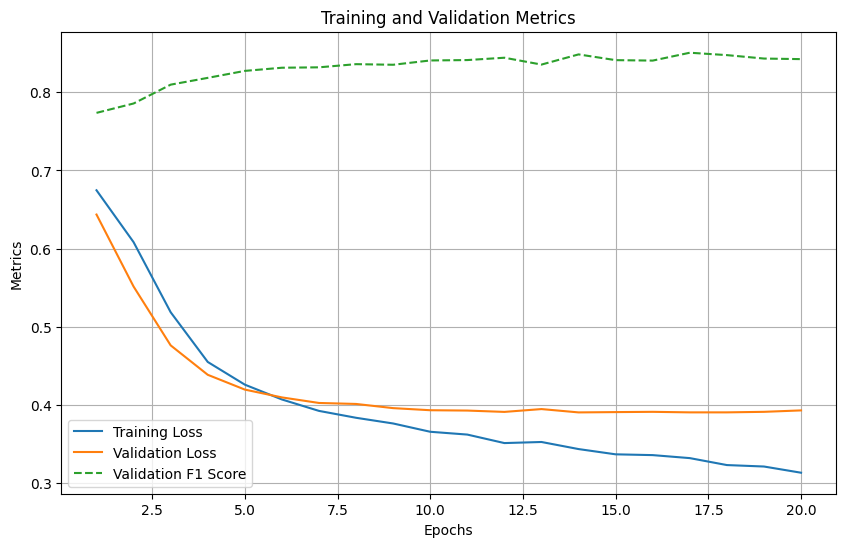

In [19]:
# Plot Metrics vs Epochs
DistilBERT.plot_metrics(log_path)

In [20]:
# Predict on new data
predictions = DistilBERT.predict(list(test['text']))
print(predictions)

[1 1 1 ... 1 1 1]


In [21]:
# Find the best epoch
log = pd.read_csv(log_path)
min_val_loss = log['Validation Loss'].min()
a = log.loc[pd.read_csv(log_path)['Validation Loss'] == min_val_loss]
print(a)
print(f'Minimum validation loss: {min_val_loss}')

    Epoch  Training Loss  Validation Loss  Validation F1 Score  \
13     14        0.34382         0.390689             0.848302   

    Validation Accuracy  
13             0.846356  
Minimum validation loss: 0.3906891566390792


In [22]:
# Submit the best epoch
predictions = DistilBERT.predict(list(test['text']), model_path='DistilBERT_epoch15.model')
print(predictions)
BERT_submission = pd.DataFrame(columns=['id', 'target'])
BERT_submission['id'] = test['id']
BERT_submission['target'] = predictions

print(BERT_submission.head())
BERT_submission.to_csv('/content/drive/My Drive/NLP/BERT_submission_2.csv', index=False)

<ipython-input-16-73a0756fa542>:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


[1 1 1 ... 1 1 1]
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## 2.2 Recurrent Neural Network (RNN)

The Recurrent Neural Network (RNN) is a type of neural network architecture designed for sequential data, introduced by Elman in 1990. RNNs are particularly well-suited for tasks where the order of the data matters, making them effective for natural language processing (NLP) tasks such as text classification, language modeling, and translation. In this project, the RNN classifier serves as a powerful tool for text classification tasks, demonstrating its effectiveness and versatility.

In [23]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = clean_text(self.texts[idx])
        inputs = self.tokenizer(text, padding='max_length', max_length=self.max_length, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return input_ids, attention_mask, label
        else:
            return input_ids, attention_mask


### Below is the RNN structure

In [24]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_labels, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        rnn_out, _ = self.rnn(embedded)
        pooled_output = torch.mean(rnn_out, dim=1)
        dropout_output = self.dropout(pooled_output)
        logits = self.fc(dropout_output)
        return logits

In [25]:
class RNNTextClassifier:
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2, num_labels=2, batch_size=4, epochs=5, lr=1e-3, max_length=256):
        self.model = RNNClassifier(vocab_size, embed_size, hidden_size, num_layers, num_labels)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.encoder = LabelEncoder()
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def tokenize_data(self, texts, labels=None, tokenizer=None):
        if labels is not None:
            labels = self.encoder.fit_transform(labels)
        else:
            labels = None
        dataset = TextDataset(texts, labels, tokenizer, self.max_length)
        return dataset

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc="Training"):
            input_ids, attention_mask, labels = [b.to(self.device) for b in batch]
            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            self.optimizer.step()
        avg_loss = total_loss / len(dataloader)
        return avg_loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions, true_vals = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluation"):
                input_ids, attention_mask, labels = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                logits = outputs.detach().cpu().numpy()
                label_ids = labels.cpu().numpy()
                predictions.append(logits)
                true_vals.append(label_ids)
        avg_loss = total_loss / len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return avg_loss, predictions, true_vals

    def train(self, train_texts, train_labels, val_texts, val_labels, tokenizer):
        train_dataset = self.tokenize_data(train_texts, train_labels, tokenizer)
        val_dataset = self.tokenize_data(val_texts, val_labels, tokenizer)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=self.batch_size)
        val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=self.batch_size//2)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-' * 10)
            train_loss = self.train_epoch(train_dataloader)
            self.train_losses.append(train_loss)
            val_loss, predictions, true_vals = self.evaluate(val_dataloader)
            self.val_losses.append(val_loss)
            preds_flat = np.argmax(predictions, axis=1).flatten()
            labels_flat = true_vals.flatten()
            val_accuracy = accuracy_score(labels_flat, preds_flat)
            self.val_accuracies.append(val_accuracy)
            val_f1 = f1_score(labels_flat, preds_flat, average='weighted')
            self.val_f1_scores.append(val_f1)
            torch.save(self.model.state_dict(), f'RNN_epoch{epoch+1}.model')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'F1 Score (Weighted): {val_f1}')

    def save_log(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Accuracy'])
            for epoch in range(self.epochs):
                writer.writerow([
                    epoch+1,
                    self.train_losses[epoch],
                    self.val_losses[epoch],
                    self.val_f1_scores[epoch],
                    self.val_accuracies[epoch]
                ])

    def plot_metrics(self, filename):
        df_log = pd.read_csv(filename)
        epochs = df_log['Epoch']
        train_losses = df_log['Training Loss']
        val_losses = df_log['Validation Loss']
        val_f1_scores = df_log['Validation F1 Score']
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.plot(epochs, val_f1_scores, label='Validation F1 Score', linestyle='--')
        plt.title('Training and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, texts, tokenizer, model_path=None):
        dataset = self.tokenize_data(texts, tokenizer=tokenizer)
        dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)
        if model_path is not None:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids, attention_mask)
                logits = outputs.detach().cpu().numpy()
                predictions.append(logits)
        predictions = np.concatenate(predictions, axis=0)
        predicted_labels = (predictions[:, 1] >= 0.5).astype(int)
        return predicted_labels


In [26]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text = train['text'].values
X_train, X_val, y_train, y_val = train_test_split(text, train['target'], test_size=0.2, random_state=0)
vocab_size = tokenizer.vocab_size
rnn_classifier = RNNTextClassifier(vocab_size=vocab_size, batch_size=128, epochs=20)
rnn_classifier.model

RNNClassifier(
  (embedding): Embedding(30522, 128)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [27]:
rnn_classifier.train(X_train, y_train, X_val, y_val, tokenizer)


Epoch 1/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.74it/s]


Training Loss: 0.6867
Validation Loss: 0.6781, Validation Accuracy: 0.5817
F1 Score (Weighted): 0.4279181783566604

Epoch 2/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.80it/s]


Training Loss: 0.6724
Validation Loss: 0.6391, Validation Accuracy: 0.6034
F1 Score (Weighted): 0.5277738932100198

Epoch 3/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.79it/s]


Training Loss: 0.5975
Validation Loss: 0.5646, Validation Accuracy: 0.7354
F1 Score (Weighted): 0.724930417480981

Epoch 4/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.84it/s]


Training Loss: 0.5039
Validation Loss: 0.5326, Validation Accuracy: 0.7413
F1 Score (Weighted): 0.7316327324162532

Epoch 5/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.84it/s]


Training Loss: 0.4307
Validation Loss: 0.5191, Validation Accuracy: 0.7610
F1 Score (Weighted): 0.7533303475189898

Epoch 6/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.77it/s]


Training Loss: 0.3621
Validation Loss: 0.5296, Validation Accuracy: 0.7656
F1 Score (Weighted): 0.7636794968823233

Epoch 7/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.81it/s]


Training Loss: 0.2997
Validation Loss: 0.5795, Validation Accuracy: 0.7636
F1 Score (Weighted): 0.7626757869316475

Epoch 8/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.80it/s]


Training Loss: 0.2609
Validation Loss: 0.5874, Validation Accuracy: 0.7577
F1 Score (Weighted): 0.7564982950928623

Epoch 9/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.81it/s]


Training Loss: 0.2278
Validation Loss: 0.6587, Validation Accuracy: 0.7656
F1 Score (Weighted): 0.7634400723318308

Epoch 10/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.82it/s]


Training Loss: 0.2054
Validation Loss: 0.8136, Validation Accuracy: 0.7571
F1 Score (Weighted): 0.7564135749399771

Epoch 11/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]


Training Loss: 0.1970
Validation Loss: 0.9521, Validation Accuracy: 0.7564
F1 Score (Weighted): 0.7568714892072941

Epoch 12/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]


Training Loss: 0.1732
Validation Loss: 0.8852, Validation Accuracy: 0.7518
F1 Score (Weighted): 0.7510812951228892

Epoch 13/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.78it/s]


Training Loss: 0.1648
Validation Loss: 0.7420, Validation Accuracy: 0.7617
F1 Score (Weighted): 0.7608628901805089

Epoch 14/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.56it/s]


Training Loss: 0.1520
Validation Loss: 1.0784, Validation Accuracy: 0.7518
F1 Score (Weighted): 0.7512114385640278

Epoch 15/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.61it/s]


Training Loss: 0.1451
Validation Loss: 0.9551, Validation Accuracy: 0.7538
F1 Score (Weighted): 0.7547332684331662

Epoch 16/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.65it/s]


Training Loss: 0.1399
Validation Loss: 1.1271, Validation Accuracy: 0.7564
F1 Score (Weighted): 0.755911993175983

Epoch 17/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.66it/s]


Training Loss: 0.1331
Validation Loss: 1.0267, Validation Accuracy: 0.7518
F1 Score (Weighted): 0.7505957164737062

Epoch 18/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.68it/s]


Training Loss: 0.1291
Validation Loss: 1.1306, Validation Accuracy: 0.7590
F1 Score (Weighted): 0.7580271273870371

Epoch 19/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.70it/s]


Training Loss: 0.1238
Validation Loss: 1.1034, Validation Accuracy: 0.7531
F1 Score (Weighted): 0.7529513005857189

Epoch 20/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00, 10.74it/s]


Training Loss: 0.1166
Validation Loss: 1.2447, Validation Accuracy: 0.7472
F1 Score (Weighted): 0.7465051905128616


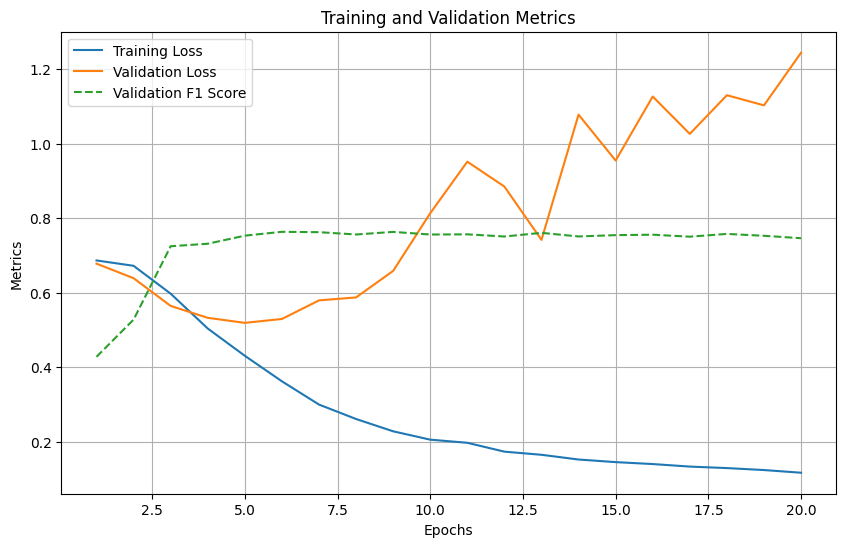

In [28]:
rnn_log_path = '/content/drive/My Drive/NLP/rnn_training_log.csv'
rnn_classifier.save_log(rnn_log_path)
rnn_classifier.plot_metrics(rnn_log_path)

In [29]:
# Predict on new data
predictions = rnn_classifier.predict(list(test['text']), tokenizer=tokenizer)
print(predictions)

[1 0 1 ... 1 1 1]


In [30]:
# Find the best epoch
log = pd.read_csv(rnn_log_path)
min_val_loss = log['Validation Loss'].min()
a = log.loc[pd.read_csv(rnn_log_path)['Validation Loss'] == min_val_loss]
print(a)
print(f'Minimum validation loss: {min_val_loss}')

   Epoch  Training Loss  Validation Loss  Validation F1 Score  \
4      5       0.430684          0.51913              0.75333   

   Validation Accuracy  
4             0.760998  
Minimum validation loss: 0.5191301504770914


In [31]:
# Submit the best epoch
predictions = rnn_classifier.predict(list(test['text']), tokenizer=tokenizer, model_path='RNN_epoch19.model')
print(predictions)
RNN_submission = pd.DataFrame(columns=['id', 'target'])
RNN_submission['id'] = test['id']
RNN_submission['target'] = predictions

print(RNN_submission.head())
RNN_submission.to_csv('/content/drive/My Drive/NLP/RNN_submission_2.csv', index=False)

<ipython-input-25-b20cb71f2b72>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


[1 0 1 ... 1 1 1]
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1


______
# 3. Results and Analysis
______



## 3.1 Training Log Analysis

In [32]:
BERT_log_df = pd.read_csv(log_path)
rnn_log_df = pd.read_csv(rnn_log_path)

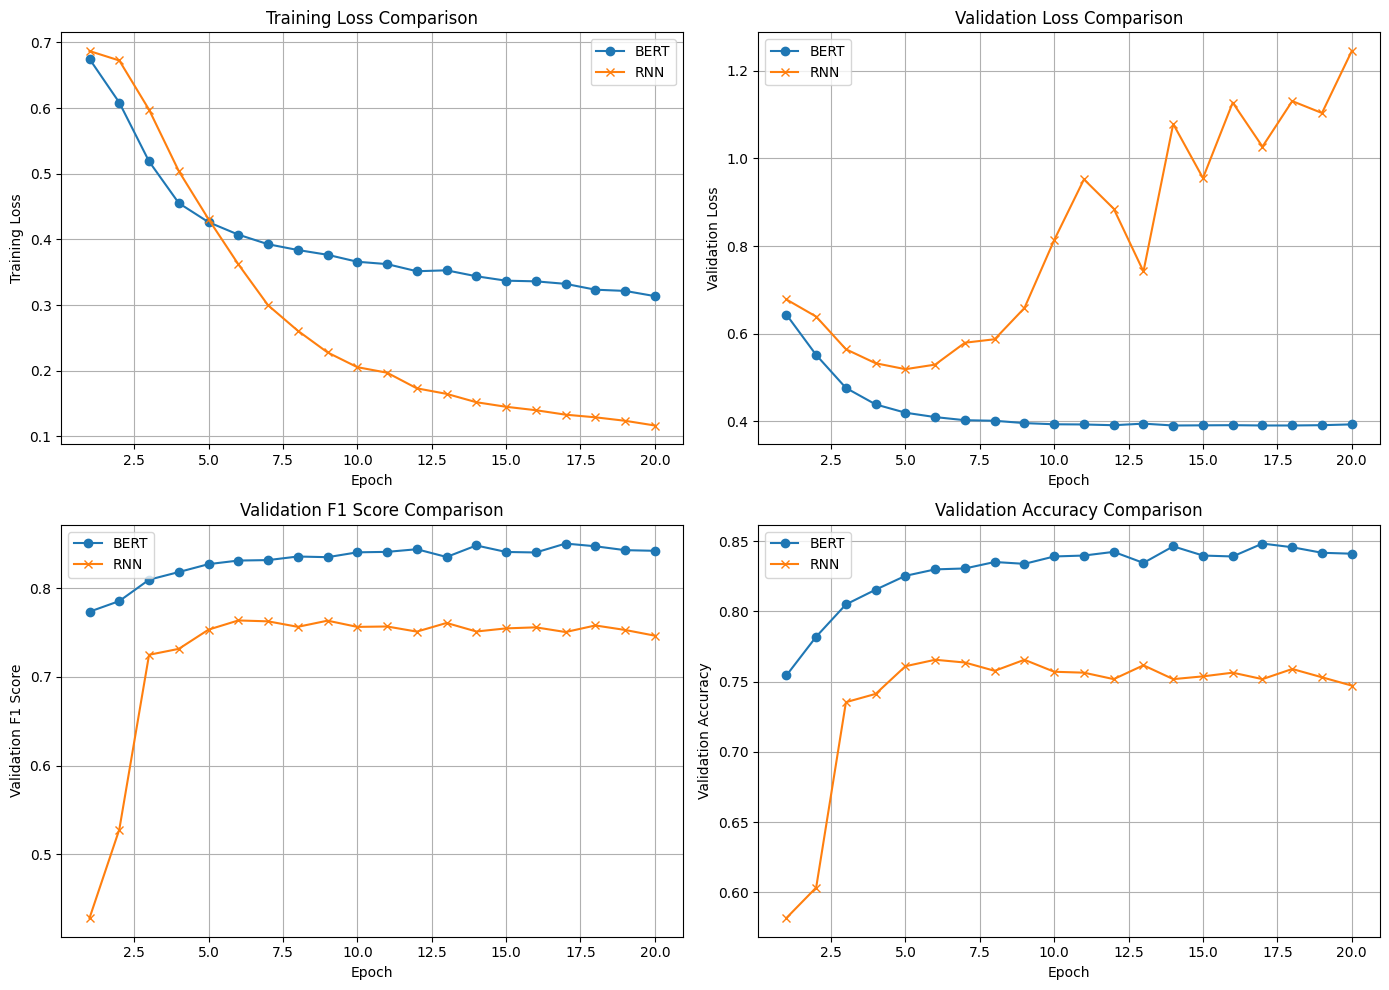

In [33]:
# Create plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].plot(BERT_log_df['Epoch'], BERT_log_df['Training Loss'], label='BERT', marker='o')
ax[0, 0].plot(rnn_log_df['Epoch'], rnn_log_df['Training Loss'], label='RNN', marker='x')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Training Loss')
ax[0, 0].set_title('Training Loss Comparison')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(BERT_log_df['Epoch'], BERT_log_df['Validation Loss'], label='BERT', marker='o')
ax[0, 1].plot(rnn_log_df['Epoch'], rnn_log_df['Validation Loss'], label='RNN', marker='x')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Validation Loss')
ax[0, 1].set_title('Validation Loss Comparison')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(BERT_log_df['Epoch'], BERT_log_df['Validation F1 Score'], label='BERT', marker='o')
ax[1, 0].plot(rnn_log_df['Epoch'], rnn_log_df['Validation F1 Score'], label='RNN', marker='x')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Validation F1 Score')
ax[1, 0].set_title('Validation F1 Score Comparison')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(BERT_log_df['Epoch'], BERT_log_df['Validation Accuracy'], label='BERT', marker='o')
ax[1, 1].plot(rnn_log_df['Epoch'], rnn_log_df['Validation Accuracy'], label='RNN', marker='x')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Validation Accuracy')
ax[1, 1].set_title('Validation Accuracy Comparison')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

We can see that distlBERT converges faster at early epochs, and RNN is not that stable compares with distilBERT.

### Looking at the F1 score and accuracy, distlBERT is more stable compared with RNN. The training and validation loss of distlBERT converge faster at the early epoch, e.g.when epoch is less than 5, then gets lowly.

## 3.2 Kaggle Submission Scores

|Models                                  | Score |
|---------------------------------------------------------------|---------------|
| distilBERT 15 epochs | 0.82929       |
|  RNN 19 epochs  | 0.74440       |


### As per the submission score, distilBERT performs better than RNN.

______
# 4. Conclusions
______



## 4.1 DistilBERT
DistilBERT shows significant promise and high accuracy even in the initial epochs, thanks to its pre-trained weights. It continues to improve with more training, maintaining robust performance and stability, which makes it an excellent choice for text classification tasks.
The combination of efficiency, pre-trained knowledge, and contextual understanding gives it a distinct advantage in text classification tasks, achieving high accuracy and fast convergence.

## 4.2 RNN
Recurrent Neural Networks (RNNs), particularly those using Long Short-Term Memory (LSTM) cells, are designed to handle sequential data, making them effective for tasks like text classification. However, compared to more modern architectures like DistilBERT, RNNs may require more tuning and longer training times to achieve similar levels of performance.

#### For this project, DistilBERT’s efficiency and robust pre-training give it a significant advantage in text classification tasks, leading to higher accuracy and faster convergence.